# YARA-ing with MacOS

MacOS malware, and MACHO samples, represent the next frontier for many burgeoning threat intelligence professionals. Before we get started, this post cannot happen without referencing senpai Patrick Wardle. Read his blog on [Objective-See](https://objective-see.org/blog/blog_0x71.html), and read his dang book on the [Art of Mac Malware](https://taomm.org/) (ITS FREE) since many of the techniques herein for triage and analysis are taken from his work. 

this piece will focus much more on writing a good rule or two to track a particular malware family. 

Today our specimen will be CloudMensis, first disclosed by [ESET](https://www.welivesecurity.com/2022/07/19/i-see-what-you-did-there-look-cloudmensis-macos-spyware/) and also analyzed by [Volexity](https://www.youtube.com/watch?v=qCwHwfFmMfI), which attributed the family to APT37. We're going to look at the spyware component not the loader. 

Lets start with binary refinery to read it in:

In [1]:
!emit /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd | peek

-------------------------------------------------------------------------------
01.393 MB; 74.47% entropy; Mach-O universal binary with 2 architectures: [x86_64:Mach-O 64-bit x86_64 executable, flags:<NOUNDEFS|DYLDLINK|TWOLEVEL|PIE>] [arm64:Mach-O 64-bit arm64 executable, flags:<NOUNDEFS|DYLDLINK|TWOLEVEL|PIE>]
-------------------------------------------------------------------------------
00000000: CA FE BA BE 00 00 00 02 01 00 00 07 00 00 00 03 00  .................
00000011: 00 40 00 00 0A 8F 20 00 00 00 0E 01 00 00 0C 00 00  .@...............
00000022: 00 00 00 0B 00 00 00 0A 3F 80 00 00 00 0E 00 00 00  ........?........
00000033: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  .................
........: //////////////// repeats 5 times /////////////////  /////////////////
00000099: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  .................
-------------------------------------------------------------------------------


Okay so it looks like a multi-bin macho! That mostly means there are two embedded macho files, one for Intel architecture one for ARM. This is further highlighted by the otool native on MacOS, which will display data from the Macho headers.

In [6]:
!otool -fv /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd | less

Fat headers1h=
fat_magic FAT_MAGIC
nfat_arch 2
architecture x86_64
    cputype CPU_TYPE_X86_64
    cpusubtype CPU_SUBTYPE_X86_64_ALL
    capabilities 0x0
    offset 16384
    size 692000
    align 2^14 (16384)
architecture arm64
    cputype CPU_TYPE_ARM64
    cpusubtype CPU_SUBTYPE_ARM64_ALL
    capabilities 0x0
    offset 720896
    size 671616
    align 2^14 (16384)
(END)Fat headers
fat_magic FAT_MAGIC
nfat_arch 2
architecture x86_64
    cputype CPU_TYPE_X86_64
    cpusubtype CPU_SUBTYPE_X86_64_ALL
    capabilities 0x0
    offset 16384
    size 692000
    align 2^14 (16384)
architecture arm64
    cputype CPU_TYPE_ARM64
    cpusubtype CPU_SUBTYPE_ARM64_ALL
    capabilities 0x0
    offset 720896
    size 671616
    align 2^14 (16384)
~
~
~
~
~
~
(END)

### Use Lipo To Deflate

Next we can rip out the Intel binary from the universaly binary format using a tool, ironically, called lipo. We can then check any validity of the code signing using `spctl -a -v` and checking signer info with `codesign -dvv`

In [ ]:
!lipo /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd -thin x86_64 -output /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary

In [22]:
!spctl -a -v /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary

/Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary: rejected


In [26]:
!codesign -dvv /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary

Executable=/Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary
Identifier=Client-55554944ad0c6122f4393d7a831706fbda3b38ac
Format=Mach-O thin (x86_64)
CodeDirectory v=20400 size=5608 flags=0x2(adhoc) hashes=164+7 location=embedded
Signature=adhoc
Info.plist=not bound
TeamIdentifier=not set
Sealed Resources=none
Internal requirements count=0 size=12


## Macho Structure 

I think its helpful to get an idea of the overall structure of the Macho binary we'll be investigating now that we've carved it from the universal binary format. 

![](https://www.oreilly.com/api/v2/epubs/9781785883378/files/graphics/B05055_02_38.jpg)

The image above highlights the things of general interest, including the header, the load commmands, and the relevant segments, which contain embedded sections. We could hash these the way we do with PE's, but they can give us some tells about the binary such as the source language

Others have written extensively about the Macho file format, and malware analysis:
- Again, the GOAT of Mac Malware Analysis Patrick Wardle Wrote a whole FREE book on it [TAOMM](https://taomm.org/vol1/pdfs/CH%205%20Binary%20Triage.pdf)
- Phil Stokes from SentinelOne [How to Reverse Malware on macOS Without Getting Infected](https://go.sentinelone.com/rs/327-MNM-087/images/reverse_mw_final_9.pdf) - Page 20
- Scott Lester from RedMaple wrote a deep dive on the file format [So Macho - A look at Apple executable files](https://redmaple.tech/blogs/macho-files/)

For our purposes today, we'll focus on the segments and sections found in the binary. If we use binary refinery's vsect command to show `virtual sections` it will highlight the segments and their sub-sections

In [21]:
!emit /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary | vsect -l

__PAGEZERO
__TEXT
__TEXT/__text
__TEXT/__stubs
__TEXT/__stub_helper
__TEXT/__gcc_except_tab
__TEXT/__cstring
__TEXT/__objc_methname
__TEXT/__objc_classname
__TEXT/__objc_methtype
__TEXT/__ustring
__TEXT/__const
__TEXT/__unwind_info
__DATA
__DATA/__nl_symbol_ptr
__DATA/__got
__DATA/__la_symbol_ptr
__DATA/__const
__DATA/__cfstring
__DATA/__objc_classlist
__DATA/__objc_nlclslist
__DATA/__objc_catlist
__DATA/__objc_protolist
__DATA/__objc_imageinfo
__DATA/__objc_const
__DATA/__objc_selrefs
__DATA/__objc_protorefs
__DATA/__objc_classrefs
__DATA/__objc_superrefs
__DATA/__objc_ivar
__DATA/__objc_data
__DATA/__data
__DATA/__bss
__DATA/__common
__LINKEDIT


Executing the above command to dump out all of the segments and sections therein, we have out 'tell' for how we will analyze this binary. Seeing that this sample uses Objective-C, in my opinion, changes where we will focus our next efforts. How do we know that? In the __DATA segment, we can see extensive references to __objc, including a classlist, protolists, and what are probably some constants. 

So we'll use the lovely class-dump tool to, well, do what it says on the tin

In [27]:
!class-dump /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary

//
//     Generated by class-dump 3.5 (64 bit).
//
//     class-dump is Copyright (C) 1997-1998, 2000-2001, 2004-2013 by Steve Nygard.
//

#pragma mark Function Pointers and Blocks

typedef void (*CDUnknownFunctionPointerType)(void); // return type and parameters are unknown

typedef void (^CDUnknownBlockType)(void); // return type and parameters are unknown

#pragma mark Named Structures

struct _SYSTEMTIME {
    unsigned short _field1;
    unsigned short _field2;
    unsigned short _field3;
    unsigned short _field4;
    unsigned short _field5;
    unsigned short _field6;
    unsigned short _field7;
    unsigned short _field8;
};

struct __sFILE {
    char *_field1;
    int _field2;
    int _field3;
    short _field4;
    short _field5;
    struct __sbuf _field6;
    int _field7;
    void *_field8;
    CDUnknownFunctionPointerType _field9;
    CDUnknownFunctionPointerType _field10;
    CDUnknownFunctionPointerType _field11;
    CDUnknownFunctionPointerType _field12;
    struct __sbu

Now while we could have just used strings or carve or floss to show those, getting this data back in a somewhat structured format makes eyeballing it a lot easier, at least for me. 

In [9]:
!class-dump /Users/glesnewich/Projects/Malware/Samples/Komplex/xagent | grep @interface | sort 


@interface AppDelegate : NSObject <NSApplicationDelegate>
@interface Base64 : NSObject
@interface BootXLoader : NSObject
@interface CameraShot : NSObject
@interface FMServer : NSObject
@interface FMThread : NSObject
@interface FTP : NSObject
@interface FTPManager : NSObject <NSStreamDelegate>
@interface FileObserver : NSObject
@interface FileSystem : NSObject
@interface HTTPChannel : NSObject
@interface InjectApp : NSObject
@interface Keylogger : NSObject
@interface Launcher : NSObject
@interface MainHandler : NSObject
@interface NSObject (NSObject_SBJsonWriting)
@interface NSString (FTPManagerNSStringAdditions)
@interface NSString (NSString_SBJsonParsing)
@interface NSURLConnection (SelfSigned)
@interface NSURLConnectionDelegateWrapper : NSObject <NSURLConnectionDelegate, NSURLConnectionDataDelegate>
@interface Password : NSObject
@interface RemoteShell : NSObject
@interface SBJsonParser : NSObject
@interface SBJsonStreamParser : NSObject
@interface SBJsonStreamParserAccumulator : NSO

A few things stand out (trimmed for brevity) 

```
struct cmdPacket {
    unsigned char cmd;
    char *param;
    unsigned long long param_size;
};

struct msgPacket {
    int agent_id;
    short module_id;
    unsigned char cmd_id;
    char *data_;
    unsigned int data_size;
    unsigned char priority;
};

__attribute__((visibility("hidden")))
@interface Keylogger : NSObject
{
    struct __CFMachPort *_eventTap;
    NSArray *_viewProcess;
    NSThread *_logThread;
    NSMutableString *_logData;
    unsigned long long _countKeyLog;
    int _logLength;
    BOOL _keylogger_status;
    BOOL _isActiveProcess;
    id _keyPressedeventMonitor;
}

@property(retain, nonatomic) id keyPressedeventMonitor; // @synthesize keyPressedeventMonitor=_keyPressedeventMonitor;
- (void).cxx_destruct;
- (void)removeNotificationForActiveApp;
- (void)addNotificationForActiveApp;
- (void)activeAppDidChange:(id)arg1;
- (void)sendLog;
- (void)disableLogging;
- (void)enableLogging;
- (void)stop;
- (void)start;
- (BOOL)status;
- (void)pressedKeyWithKeyCode:(unsigned short)arg1 andModifiers:(unsigned long long)arg2;
- (char *)checkSpecialKey:(unsigned short)arg1;
- (BOOL)checkAccesibility;
- (BOOL)setAccessibilityApplication;
- (BOOL)initEventTapAndStartRunLoop;
- (id)init;

@end

__attribute__((visibility("hidden")))
@interface MainHandler : NSObject
{
    FTP *ftp;
    BOOL _isScreenShotEnable;
    NSThread *_screenShotThread;
    HTTPChannel *http_param;
}

- (void).cxx_destruct;
- (void)cycleLoop;
- (void)ftpStop;
- (void)ftpUpload;
- (void)ftpNotificationServer:(id)arg1;
- (void)sendKeyLog:(id)arg1;
- (void)stopTakeScreenShot;
- (void)startTakeScreenShot;
- (void)screenShotLoop;
- (void)takeScreenShot;
- (void)deletFileFromPath;
- (void)execFile;
- (void)createFileInSystem;
- (void)downloadFileFromPath;
- (void)readFiles;
- (void)showBackupIosFolder;
- (void)getInstalledAPP;
- (void)remoteShell;
- (void)getProcessList;
- (void)getInfoOSX;
- (void)getFirefoxPassword;
- (void)ftpMsg:(char *)arg1 size:(unsigned int)arg2 cmdId:(unsigned char)arg3;
- (void)keyloggerMsg:(char *)arg1 size:(unsigned int)arg2 cmdId:(unsigned char)arg3;
- (void)screenShotMsg:(char *)arg1 size:(unsigned int)arg2 cmdId:(unsigned char)arg3;
- (void)fileSystemMsg:(char *)arg1 size:(unsigned int)arg2 cmdId:(unsigned char)arg3;
- (void)buildMsg:(char *)arg1 size:(unsigned int)arg2 cmdId:(unsigned char)arg3;
- (id)init;

@end

__attribute__((visibility("hidden")))
@interface BootXLoader : NSObject
{
}

- (void)runLoader:(const char *)arg1;
- (void)injectApplication;
- (_Bool)online;
- (void)getThread:(id)arg1;
- (void)postThread:(id)arg1;
- (void)modulesThread:(id)arg1;

@end


```

One can also find intresting attributes by using grep

In [6]:
!class-dump /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary | grep @interface | sort -rn


@interface screen_keylog : NSObject
@interface pCloud : Cloud
@interface get_comInfo : NSObject
@interface functions : NSObject
@interface control_thread : NSObject
@interface _AFURLSessionTaskSwizzling : NSObject
@interface Yandex : Cloud
@interface SSZipArchive : NSObject
@interface NSString (SSZipArchive)
@interface NSData (SSZipArchive)
@interface MyTCC : NSObject
@interface Management : NSObject
@interface FileTreeXML : NSObject
@interface Dropbox : Cloud
@interface Cloud : NSObject
@interface CSSMRSACryptor : NSObject
@interface CCMPublicKey : NSObject
@interface CCMPrivateKey : NSObject
@interface CCMKeyLoader : NSObject
@interface CCMCryptor : NSObject
@interface CCMBase64 : NSObject
@interface AppDelegate : NSObject
@interface AFXMLParserResponseSerializer : AFHTTPResponseSerializer
@interface AFXMLDocumentResponseSerializer : AFHTTPResponseSerializer
@interface AFURLSessionManagerTaskDelegate : NSObject <NSURLSessionTaskDelegate, NSURLSessionDataDelegate, NSURLSessionDownload

So that looks cool right? Screen_keylog sounds fun

```
__attribute__((visibility("hidden")))
@interface screen_keylog : NSObject
{
    int lastScreenLen;
}

- (void)loop_usb;
- (void)keyLogger;
- (id)getScreenShotData;
- (void)searchRemovable;
- (void)keylog;
- (void)runKeyScreenFunc;

@end
```

and a similarly sus function

```
@interface get_comInfo : NSObject
{
}

+ (BOOL)initCloudDataDirectories;
+ (BOOL)initCloudCmdDirectories;
+ (void)getDiskUsage;
+ (float)getProcessMemory;
+ (float)getMemoryUsed;
+ (unsigned long long)getMyFileSize:(id)arg1;
+ (id)getMyFileModified:(id)arg1;
+ (struct _SYSTEMTIME)getCurrentTimeAsStruct;
+ (unsigned int)getCurrentTimeAsDWORD;
+ (id)getLoginName;
+ (id)strControlEntry:(id)arg1;
+ (BOOL)getSysBit;
+ (long long)getMacPatchVersion;
+ (long long)getMacMinorVersion;

@end
```

so this gives us some immediate functionality that we can hone in on for crafting a nice rule! Lets first start with strings. For whatever reason, many of the subroutines get appended with the interface name, so lets look for those 

In [10]:
!emit /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary | carve printable --min=15 | grep get_comInfo | sort | uniq

+[get_comInfo getCurrentTimeAsDWORD]
+[get_comInfo getCurrentTimeAsStruct]
+[get_comInfo getDiskUsage]
+[get_comInfo getLoginName]
+[get_comInfo getMacMinorVersion]
+[get_comInfo getMacPatchVersion]
+[get_comInfo getMemoryUsed]
+[get_comInfo getMyFileModified:]
+[get_comInfo getMyFileSize:]
+[get_comInfo getProcessMemory]
+[get_comInfo getSysBit]
+[get_comInfo initCloudCmdDirectories]
+[get_comInfo initCloudDataDirectories]
+[get_comInfo strControlEntry:]
/Volumes/Data/LeonWork/MainTask/BaD/Client_v29/DerivedData/Build/Intermediates.noindex/Client.build/Release/Client.build/Objects-normal/x86_64/get_comInfo.o
_OBJC_CLASS_$_get_comInfo
_OBJC_METACLASS_$_get_comInfo
__OBJC_$_CLASS_METHODS_get_comInfo
__OBJC_CLASS_RO_$_get_comInfo
__OBJC_METACLASS_RO_$_get_comInfo


Lets do it again for screen_keylog

In [11]:
!emit /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary | carve printable --min=15 | grep screen_keylog | sort | uniq

-[screen_keylog getScreenShotData]
-[screen_keylog keyLogger]
-[screen_keylog keylog]
-[screen_keylog loop_usb]
-[screen_keylog runKeyScreenFunc]
-[screen_keylog searchRemovable]
/Volumes/Data/LeonWork/MainTask/BaD/Client_v29/DerivedData/Build/Intermediates.noindex/Client.build/Release/Client.build/Objects-normal/x86_64/screen_keylog.o
_OBJC_CLASS_$_screen_keylog
_OBJC_IVAR_$_screen_keylog.lastScreenLen
_OBJC_METACLASS_$_screen_keylog
__OBJC_$_INSTANCE_METHODS_screen_keylog
__OBJC_$_INSTANCE_VARIABLES_screen_keylog
__OBJC_CLASS_RO_$_screen_keylog
__OBJC_METACLASS_RO_$_screen_keylog
screen_keylog.m


There is also this other odd interface called functions with a lot of fun looking names in it:
```
__attribute__((visibility("hidden")))
@interface functions : NSObject
{
}

- (id)RSAEncryptData:(id)arg1;
- (void)FlowEncrypt:(char *)arg1:(unsigned long long)arg2:(unsigned char)arg3;
- (unsigned long long)NSStringToBytes:(id)arg1:(char *)arg2:(unsigned long long)arg3;
- (unsigned long long)BytesToNSString:(char *)arg1:(unsigned long long)arg2:(id)arg3:(unsigned long long)arg4;
- (BOOL)CheckScreenSaverState;
- (BOOL)CheckSIPDisabled;
- (void)DivideFile:(id)arg1;
- (BOOL)EncryptMyFile:(id)arg1 encrypt:(BOOL)arg2 key:(unsigned char)arg3 afterDelete:(BOOL)arg4;
- (void)EMAILSearchAndMoveFS;
- (void)SearchAndMoveFS:(id)arg1 removable:(BOOL)arg2;
- (BOOL)MakeSureDirectoryPathExists:(id)arg1;
- (id)randPathWithPrefix:(BOOL)arg1 isZip:(BOOL)arg2;
- (void)ZipAndMoveZS:(id)arg1 prefix:(BOOL)arg2 sizelimit:(BOOL)arg3 subdir:(BOOL)arg4 afterDelete:(BOOL)arg5;
- (void)GetIpAndCountryCode:(id)arg1;
- (BOOL)CreatePlistFileAt:(id)arg1 withLabel:(id)arg2 exePath:(id)arg3 exeType:(int)arg4 keepAlive:(BOOL)arg5;
- (void)UploadFileImmediately:(id)arg1 CMD:(int)arg2 delete:(BOOL)arg3;
- (void)ExecuteShellCmdAndUpload:(id)arg1;
- (void)ExecuteCmdAndSaveResult:(id)arg1 saveResult:(BOOL)arg2 uploadImmediately:(BOOL)arg3;
- (void)GetFilePropertySHA1:(id)arg1 sha1Result:(char *)arg2;
- (void)MoveToFileStore:(id)arg1 Copy:(BOOL)arg2;
- (void)RenameObject:(id)arg1 destName:(id)arg2;
- (void)DeleteObject:(id)arg1 removeSource:(BOOL)arg2;
- (BOOL)CheckToCopy:(id)arg1;
- (void)PrintSHA1FileTable;
- (void)LoadSHA1FileTable;

@end
```

Lets go looking for that odd functions flag too 

In [14]:
!emit /Users/glesnewich/Projects/Malware/APT37/CloudMensis/b8a_intel_binary | carve printable --min=15 | grep '\-\[functions' | sort | uniq

-[functions BytesToNSString::::]
-[functions CheckSIPDisabled]
-[functions CheckScreenSaverState]
-[functions CheckToCopy:]
-[functions CreatePlistFileAt:withLabel:exePath:exeType:keepAlive:]
-[functions DeleteObject:removeSource:]
-[functions DivideFile:]
-[functions EMAILSearchAndMoveFS]
-[functions EncryptMyFile:encrypt:key:afterDelete:]
-[functions ExecuteCmdAndSaveResult:saveResult:uploadImmediately:]
-[functions ExecuteShellCmdAndUpload:]
-[functions FlowEncrypt:::]
-[functions GetFilePropertySHA1:sha1Result:]
-[functions GetIpAndCountryCode:]
-[functions LoadSHA1FileTable]
-[functions MakeSureDirectoryPathExists:]
-[functions MoveToFileStore:Copy:]
-[functions NSStringToBytes:::]
-[functions PrintSHA1FileTable]
-[functions RSAEncryptData:]
-[functions RenameObject:destName:]
-[functions SearchAndMoveFS:removable:]
-[functions UploadFileImmediately:CMD:delete:]
-[functions ZipAndMoveZS:prefix:sizelimit:subdir:afterDelete:]
-[functions randPathWithPrefix:isZip:]
___33-[functions E

so from all of these findings already we can start to write out some strings for our yara rule!

```

rule APT_NK_APT37_CloudMensis_ClassData
{
		meta:
			author = "Greg Lesnewich"
			description = "track the CloudMensis backdoor based on embedded class interface names"
			version = "1.0"
			reference = "https://www.welivesecurity.com/2022/07/19/i-see-what-you-did-there-look-cloudmensis-macos-spyware/"
			hash = "b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd"

		strings:
			$functions1 = "CreatePlistFileAt" ascii wide
			$functions2 = "EMAILSearchAndMoveFS" ascii wide
			$functions3 = "EncryptMyFile" ascii wide
			$functions4 = "ExecuteCmdAndSaveResult" ascii wide
			$functions5 = "uploadImmediately" ascii wide
			$functions6 = "ExecuteShellCmdAndUpload" ascii wide
			$functions7 = "FlowEncrypt" ascii wide
			$functions8 = "GetIpAndCountryCode" ascii wide
			$functions9 = "RSAEncryptData" ascii wide
			$functions10 = "UploadFileImmediately" ascii wide
			$functions11 = "ZipAndMoveZS" ascii wide

			$screenkeylog1 = "screen_keylog" ascii wide
			$screenkeylog2 = "keyLogger" ascii wide
			$screenkeylog3 = "keylog" ascii wide
			$screenkeylog4 = "runKeyScreenFunc" ascii wide

			$get_comInfo1 = "get_comInfo"
			$get_comInfo2 = "getCurrentTimeAsDWORD"
			$get_comInfo3 = "getCurrentTimeAsStruct"
			$get_comInfo4 = "getDiskUsage"
			$get_comInfo5 = "getLoginName"
			$get_comInfo6 = "getMacMinorVersion"
			$get_comInfo7 = "getMacPatchVersion"
			$get_comInfo8 = "getMemoryUsed"
			$get_comInfo9 = "getMyFileModified:"
			$get_comInfo10 = "getMyFileSize:"
			$get_comInfo11 = "getProcessMemory"
			$get_comInfo12 = "getSysBit"
			$get_comInfo13 = "initCloudCmdDirectories"
			$get_comInfo14 = "initCloudDataDirectories"
			$get_comInfo15 = "strControlEntry"

			$dev = "LeonWork/MainTask/BaD/Client_v" ascii wide

		condition:
			(uint32be(0x0) == 0xCAFEBABE or uint32be(0x0) == 0xCFFAEDFE) and 
			((3 of ($get_comInfo*) and (2 of ($functions*) or 1 of ($screenkeylog*))) or $dev and 3 of them)
}
```

couple of explainers:
- using the multiple header checks to verify hits on ARM and Intel variants 
- relatively loose string conditions, as we want to find these artifacts & functionalities in the form of developer fingerprints; they decided on those names, not the compiler
- the abrubt end to what looks like debug artifact is to hopefully catch Leon doing more work on the same family in the future

## Tangent - Targeted String Extraction
If we dump strings we can see many more of the functions that Leon wrote (towards the end of the file, as they are stored in the __DATA segment)

However, if we hone in on the __cstring section, we spot some other weirdness such as:
```
<key>com.apple.security.get-task-allow</key>
Client-55554944ad0c6122f4393d7a831706fbda3b38ac
include_media_info
include_deleted
include_has_explicit_shared_members
include_mounted_folders
https://api.dropboxapi.com/2/files/list_folder
autorename
https://api.dropboxapi.com/2/files/create_folder_v2
https://api.dropboxapi.com/2/files/delete_v2
https://content.dropboxapi.com/2/files/upload
{"path": "%@","mode": "add","autorename": true,"mute": false
csrutil status | grep disabled
pgrep ScreenSaverEngine
failed malloc
file:///
%@(%ld).%@
yyyyMMddHHmmss
/bin/bash
osascript
ProgramArguments
RunAtLoad
KeepAlive
SessionCreate
https://ipinfo.io/json
%@/%c%c%c%04d%02d%02d%02d%02d%02d.z%c%c
%@/$%04d%02d%02d%02d%02d%02d.%c%c%c
c24@?0@"NSURL"8@"NSError"16
/Users/%@/Library/Mail
echo ---start terminal---
%@/_MACOS_LOAD.sig
%@/%c%c%c/%04X
cloud.ini
*.doc;*.docx;*.xls;*.xlsx;*.ppt;*.pptx;*.hwp;*.hwpx;*.csv;*.pdf;*.rtf;*.amr;*.3gp;*.m4a;*.txt;*.mp3;*.jpg;*.eml;*.emlx
hw.model
%@ // %@
machdep.cpu.brand_string
/Library/Preferences/com.apple.iTunesInfo.plist
/Library/Preferences/com.apple.iTunesInfo%d.plist
chmod +x %@
xattr -c %@
[decimal]
[asterisk]
[divide]
[hyphen]
[equals]
[return]
[right-cmd]
[left-cmd]
[left-shift]
[left-option]
[left-ctrl]
[right-shift]
[right-option]
[right-ctrl]
[voldown]
[fwddel]
[pgdown]
[unknown]
```

Many of these were found dumping the CString section of __TEXT, so that area can always be a good place to mine for debug strings or other string artifacts

we can do so with a binref command `emit b8a_intel_binary | vsect __cstring | carve printable --min=10`

But we probably can do more, albeit we are relatively limited right now as the `macho` module is not currently working in YARA. So can we find something more resilient? To binja!

## Disassembling

Why are we using Binary Ninja you might ask? 
- it loads stuff FAST
- the recent macho [updates](https://binary.ninja/2022/10/28/3.2-released.html#objective-c-support) are slick 
- I wanna support the Vector35 crew trying to make a cool disassembler and analysis tool
- If I speak it into existence, maybe someone will build the YARA GUI builder for binja :)  

A little [Cheat Sheet for binja](https://gist.github.com/alexander-hanel/ab801910e594ec60f07d7583873ddac0) before we get started for those that are better at Python and API usage than I

Triaging the binary in Binary Ninja highlights some of the linked libraries, imports, and more: 

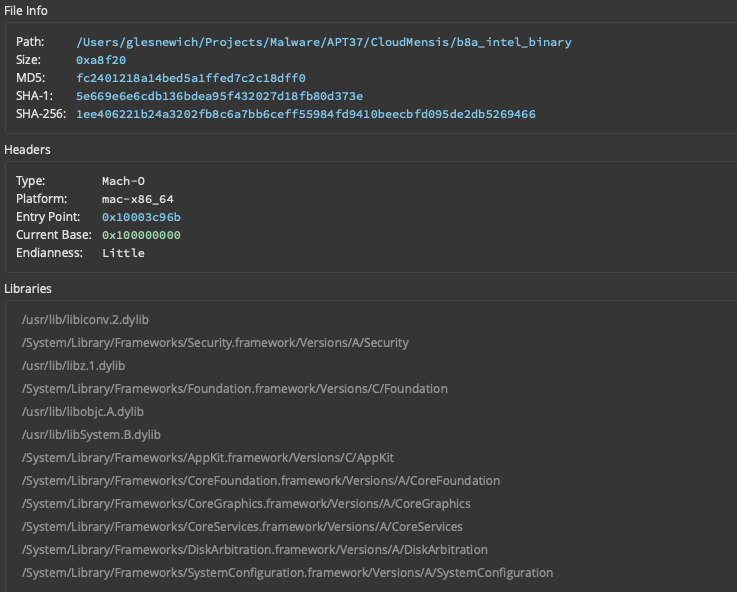



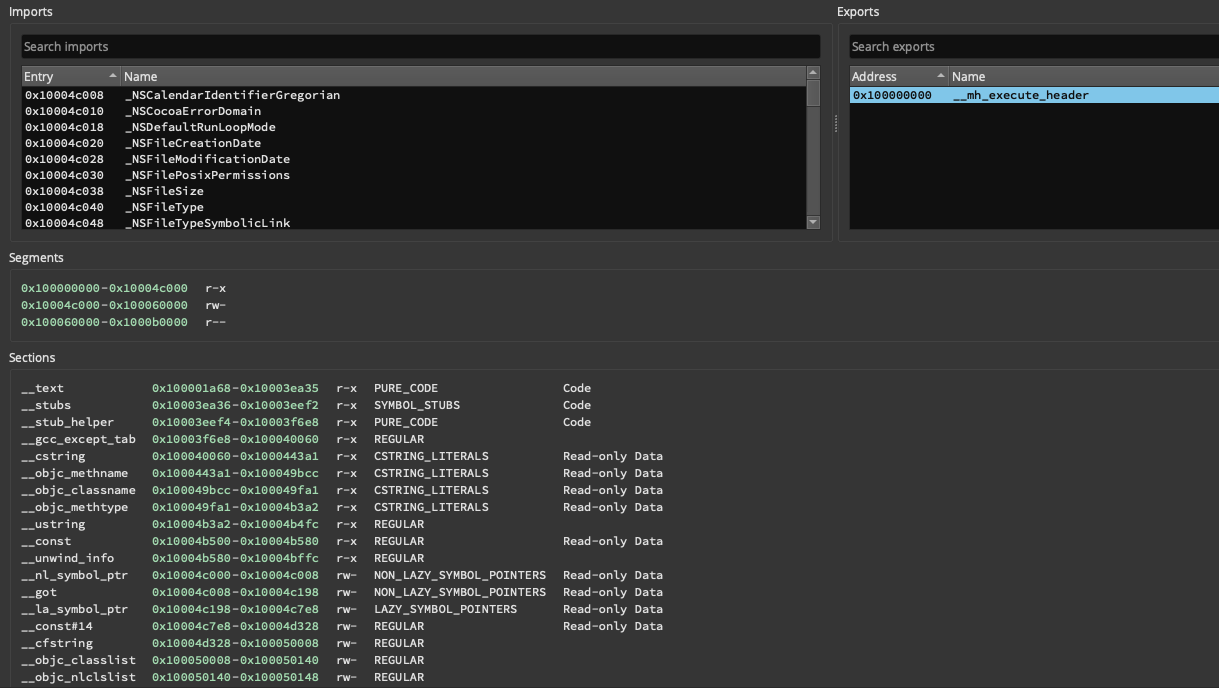

Using the binja API, we can see there are 
```
>>> print(len(list(bv.functions)))
1397
```
Lets check out whats in main with the API:
```
>>> main_func = bv.get_function_at(0x10003c96b)
>>> for inst in main_func.instructions:print(inst)
(['push', '    ', 'rbp'], 4295215467)
(['mov', '     ', 'rbp', ', ', 'rsp'], 4295215468)
(['push', '    ', 'r15'], 4295215471)
(['push', '    ', 'r14'], 4295215473)
(['push', '    ', 'rbx'], 4295215475)
(['push', '    ', 'rax'], 4295215476)
(['call', '    ', '0x10003edc6'], 4295215477)
(['mov', '     ', 'r14', ', ', 'rax'], 4295215482)
(['mov', '     ', 'rdi', ', ', 'qword ', '[', 'rel ', '0x100059770', ']'], 4295215485)
(['call', '    ', '0x10003edb4'], 4295215492)
(['mov', '     ', 'rsi', ', ', 'qword ', '[', 'rel ', '0x100057ea8', ']'], 4295215497)
(['mov', '     ', 'r15', ', ', 'qword ', '[', 'rel ', '0x10004c178', ']'], 4295215504)
(['mov', '     ', 'rdi', ', ', 'rax'], 4295215511)
(['call', '    ', 'r15'], 4295215514)
(['mov', '     ', 'rbx', ', ', 'rax'], 4295215517)
(['mov', '     ', 'rsi', ', ', 'qword ', '[', 'rel ', '0x1000594d8', ']'], 4295215520)
(['mov', '     ', 'rdi', ', ', 'rax'], 4295215527)
(['call', '    ', 'r15'], 4295215530)
(['mov', '     ', 'rdi', ', ', 'rbx'], 4295215533)
(['call', '    ', 'qword ', '[', 'rel ', '0x10004c180', ']'], 4295215536)
(['mov', '     ', 'rdi', ', ', 'r14'], 4295215542)
(['call', '    ', '0x10003edc0'], 4295215545)
(['xor', '     ', 'eax', ', ', 'eax'], 4295215550)
(['add', '     ', 'rsp', ', ', '0x8'], 4295215552)
(['pop', '     ', 'rbx'], 4295215556)
(['pop', '     ', 'r14'], 4295215557)
(['pop', '     ', 'r15'], 4295215559)
(['pop', '     ', 'rbp'], 4295215561)
(['retn', '    '], 4295215562)
```

No symbols get shown with that method obviously. Lets go looking that FlowEncrypt Function ESET mentioned!



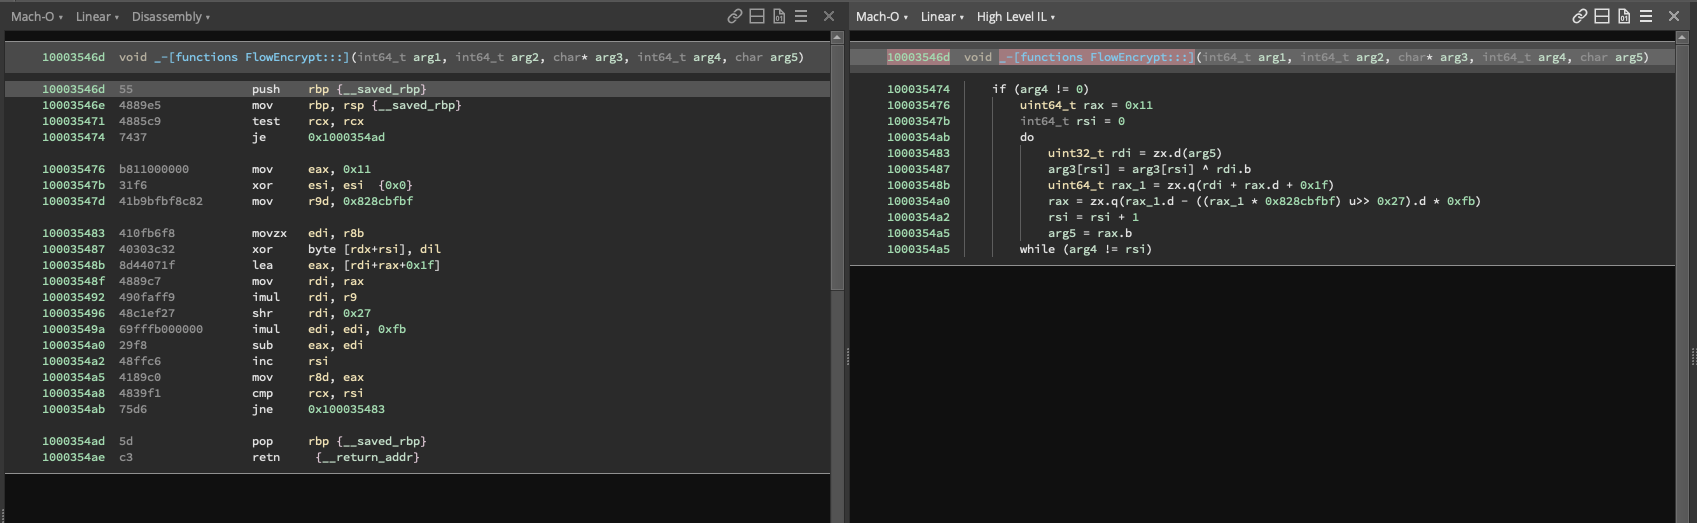


```
>>> flow_func = bv.get_function_at(here)
>>> for inst in flow_func.instructions:print(inst)
(['push', '    ', 'rbp'], 4295185517)
(['mov', '     ', 'rbp', ', ', 'rsp'], 4295185518)
(['test', '    ', 'rcx', ', ', 'rcx'], 4295185521)
(['je', '      ', '0x1000354ad'], 4295185524)
(['pop', '     ', 'rbp'], 4295185581)
(['retn', '    '], 4295185582)
(['mov', '     ', 'eax', ', ', '0x11'], 4295185526)
(['xor', '     ', 'esi', ', ', 'esi'], 4295185531)
(['mov', '     ', 'r9d', ', ', '0x828cbfbf'], 4295185533)
(['movzx', '   ', 'edi', ', ', 'r8b'], 4295185539)
(['xor', '     ', 'byte ', '[', 'rdx', '+', 'rsi', ']', ', ', 'dil'], 4295185543)
(['lea', '     ', 'eax', ', ', '[', 'rdi', '+', 'rax', '+', '0x1f', ']'], 4295185547)
(['mov', '     ', 'rdi', ', ', 'rax'], 4295185551)
(['imul', '    ', 'rdi', ', ', 'r9'], 4295185554)
(['shr', '     ', 'rdi', ', ', '0x27'], 4295185558)
(['imul', '    ', 'edi', ', ', 'edi', ', ', '0xfb'], 4295185562)
(['sub', '     ', 'eax', ', ', 'edi'], 4295185568)
(['inc', '     ', 'rsi'], 4295185570)
(['mov', '     ', 'r8d', ', ', 'eax'], 4295185573)
(['cmp', '     ', 'rcx', ', ', 'rsi'], 4295185576)
(['jne', '     ', '0x100035483'], 4295185579)


>>> data = bv.read(here,0x40)
>>> data.hex()
'554889e54885c97437b81100000031f641b9bfbf8c82410fb6f840303c328d44071f4889c7490faff948c1ef2769fffb00000029f848ffc64189c04839f175d6'
```

The two center loops look promising for us to signature! 

```
>>> sig = bv.read(here, 0x35)
>>> sig.hex()
'b81100000031f641b9bfbf8c82410fb6f840303c328d44071f4889c7490faff948c1ef2769fffb00000029f848ffc64189c04839f1'
```

This one is pretty simple since we can removed the last jne instruction set and focus on the odd contants being used in this operation. We can also wildcard the DWORD used in `mov   r9d, 0x828cbfbf` to make sure we're not over-relying on a particular value. 


```

rule MAL_CloudMensis_FlowEncrypt
{
		meta:
			author = "Greg Lesnewich"
			description = "track the CloudMensis malware family based on hardcoded FlowEncrypt routine"
			version = "1.0"
			reference = "https://www.welivesecurity.com/2022/07/19/i-see-what-you-did-there-look-cloudmensis-macos-spyware/"
			hash = "b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd"

		strings:
			$FlowEncrypt = { b8 11 00 00 00 31 f6 41 b9 ?? ?? ?? ?? 41 0f b6 f8 40 30 3c 32 8d 44 07 1f 48 89 c7 49 0f af f9 48 c1 ef 27 69 ff fb 00 00 00 29 f8 48 ff c6 41 89 c0 48 39 f1}

				// 0x100039363      mov   eax, 0x11
				// 0x100039368      xor   esi, esi
				// 0x10003936a      mov   r9d, 0x828cbfbf
				// 0x100039370      movzx edi, r8b
				// 0x100039374      xor   byte [rdx + rsi], dil               ; arg3
				// 0x100039378      lea   eax, [rdi + rax + 0x1f]
				// 0x10003937c      mov   rdi, rax
				// 0x10003937f      imul  rdi, r9
				// 0x100039383      shr   rdi, 0x27
				// 0x100039387      imul  edi, edi, 0xfb
				// 0x10003938d      sub   eax, edi
				// 0x10003938f      inc   rsi
				// 0x100039392      mov   r8d, eax
				// 0x100039395      cmp   rcx, rsi                            ; arg4
                

		condition:
				1 of them
}
``` 


Lets then duplicate many of those steps and check out the same function in the ARM version of CloudMensis also dumped from the universal binary

Aye what the hell, its like totally different! ARM ugh but there is a shell there for us to mimic. While all of the instructions and registers are bit funky, we can dig into that same loop!

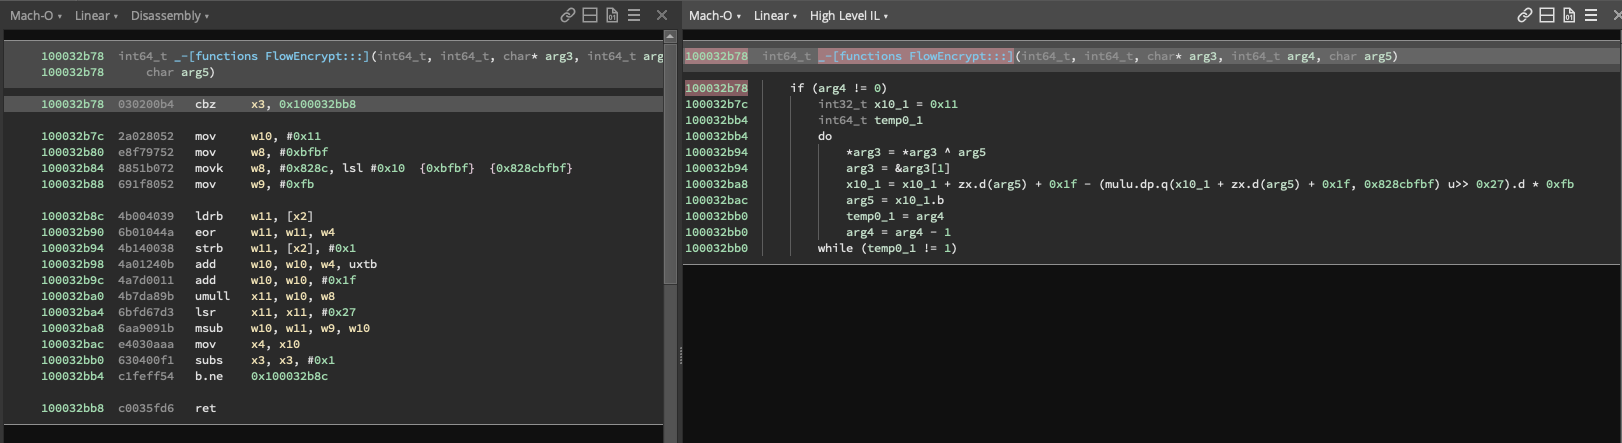

```
    x10_1 = x10_1 + zx.d(arg5) + 0x1f - (mulu.dp.q(x10_1 + zx.d(arg5) + 0x1f, 0x828cbfbf) u>> 0x27).d * 0xfb
    
    $FlowEncrypt_ARM = {4b 00 40 39 6b 01 04 4a 4b 14 00 38 4a 01 24 0b 4a 7d 00 11 4b 7d a8 9b 6b fd 67 d3 6a a9 09 1b e4 03 0a aa 63 04 00 f1 }
				// int64_t _-[functions FlowEncrypt:::](int64_t, int64_t,
				// char* arg3, int64_t arg4, char arg5)
				// 100032b78  030200b4   cbz     x3, 0x100032bb8
				// 100032b7c  2a028052   mov     w10, #0x11
				// 100032b80  e8f79752   mov     w8, #0xbfbf
				// 100032b84  8851b072   movk    w8, #0x828c, lsl #0x10  {0xbfbf}  {0x828cbfbf}
				// 100032b88  691f8052   mov     w9, #0xfb
				// 100032b8c  4b004039   ldrb    w11, [x2]
				// 100032b90  6b01044a   eor     w11, w11, w4
				// 100032b94  4b140038   strb    w11, [x2], #0x1
				// 100032b98  4a01240b   add     w10, w10, w4, uxtb
				// 100032b9c  4a7d0011   add     w10, w10, #0x1f
				// 100032ba0  4b7da89b   umull   x11, w10, w8
				// 100032ba4  6bfd67d3   lsr     x11, x11, #0x27
				// 100032ba8  6aa9091b   msub    w10, w11, w9, w10
				// 100032bac  e4030aaa   mov     x4, x10
				// 100032bb0  630400f1   subs    x3, x3, #0x1
				// 100032bb4  c1feff54   b.ne    0x100032b8c
```

Final rule:

```
rule MAL_CloudMensis_FlowEncrypt
{
		meta:
			author = "Greg Lesnewich"
			description = "track the CloudMensis malware family based on hardcoded FlowEncrypt routine"
			version = "1.0"
			reference = "https://www.welivesecurity.com/2022/07/19/i-see-what-you-did-there-look-cloudmensis-macos-spyware/"
			hash = "b8a61adccefb13b7058e47edcd10a127c483403cf38f7ece126954e95e86f2bd"

		strings:
			$FlowEncrypt = { b8 11 00 00 00 31 f6 41 b9 ?? ?? ?? ?? 41 0f b6 f8 40 30 3c 32 8d 44 07 1f 48 89 c7 49 0f af f9 48 c1 ef 27 69 ff fb 00 00 00 29 f8 48 ff c6 41 89 c0 48 39 f1}

				// 0x100039363      mov   eax, 0x11
				// 0x100039368      xor   esi, esi
				// 0x10003936a      mov   r9d, 0x828cbfbf
				// 0x100039370      movzx edi, r8b
				// 0x100039374      xor   byte [rdx + rsi], dil               ; arg3
				// 0x100039378      lea   eax, [rdi + rax + 0x1f]
				// 0x10003937c      mov   rdi, rax
				// 0x10003937f      imul  rdi, r9
				// 0x100039383      shr   rdi, 0x27
				// 0x100039387      imul  edi, edi, 0xfb
				// 0x10003938d      sub   eax, edi
				// 0x10003938f      inc   rsi
				// 0x100039392      mov   r8d, eax
				// 0x100039395      cmp   rcx, rsi                            ; arg4
                
            $FlowEncrypt_ARM = {4b 00 40 39 6b 01 04 4a 4b 14 00 38 4a 01 24 0b 4a 7d 00 11 4b 7d a8 9b 6b fd 67 d3 6a a9 09 1b e4 03 0a aa 63 04 00 f1 }
				// int64_t _-[functions FlowEncrypt:::](int64_t, int64_t,
				// char* arg3, int64_t arg4, char arg5)
				// 100032b78  030200b4   cbz     x3, 0x100032bb8
				// 100032b7c  2a028052   mov     w10, #0x11
				// 100032b80  e8f79752   mov     w8, #0xbfbf
				// 100032b84  8851b072   movk    w8, #0x828c, lsl #0x10  {0xbfbf}  {0x828cbfbf}
				// 100032b88  691f8052   mov     w9, #0xfb
				// 100032b8c  4b004039   ldrb    w11, [x2]
				// 100032b90  6b01044a   eor     w11, w11, w4
				// 100032b94  4b140038   strb    w11, [x2], #0x1
				// 100032b98  4a01240b   add     w10, w10, w4, uxtb
				// 100032b9c  4a7d0011   add     w10, w10, #0x1f
				// 100032ba0  4b7da89b   umull   x11, w10, w8
				// 100032ba4  6bfd67d3   lsr     x11, x11, #0x27
				// 100032ba8  6aa9091b   msub    w10, w11, w9, w10
				// 100032bac  e4030aaa   mov     x4, x10
				// 100032bb0  630400f1   subs    x3, x3, #0x1
				// 100032bb4  c1feff54   b.ne    0x100032b8c
		condition:
				1 of them
}

```

## Conclusion

Thats all for now folks! Next time, we'll look at a non-ObjectiveC MacOS sample for rule writing! 